In [1]:
using PyPlot

In [2]:
pu=include("plotutil.jl")

ErrorException: could not open file C:\Users\JaredMcBride\OneDrive - math.arizona.edu\Research\Model Reduction\Langevin\Python Work\plotutil.jl

**Target density**

We use the usual double-well potential
$$
V(x) = (x^2-1)^2
$$
and target density
$$
\pi^*(x) \propto e^{-\beta V(x)}
$$
with $\beta=8$.

In [3]:
V(x) = (x^2-1)^2

V (generic function with 1 method)

In [4]:
DV(x) = 2*(x^2-1)*2*x

DV (generic function with 1 method)

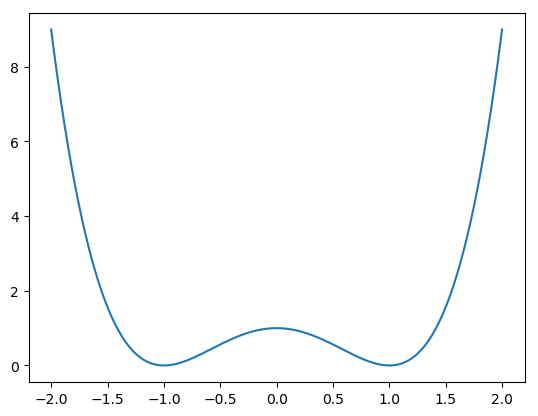

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000003091D8D0>

In [5]:
let xl = -2:0.01:2
    plot(xl,map(V,xl))
end

In [6]:
beta=8

8

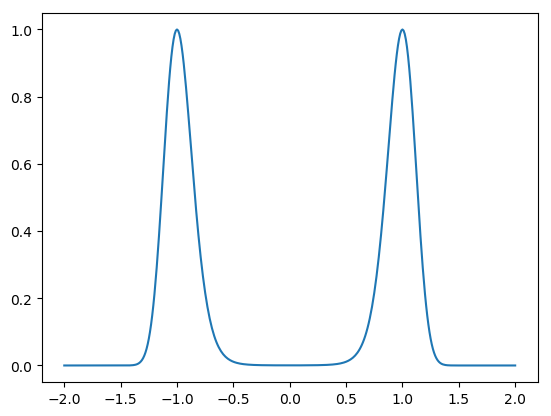

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000030AF0CF8>

In [7]:
let xl = -2:0.01:2
    plot(xl,map(x->exp(-beta*V(x)),xl))
end

**Metropolis-Hastings sampler**

Using a gaussian random walk proposal.

In [8]:
function MHStepper(; beta=1, sigma=0.1)
    function onestep(x)
        y = x + sigma*randn()
        if rand() <= exp(-beta*(V(y)-V(x)))
            return y
        else
            return x
        end
    end
end

MHStepper (generic function with 1 method)

**Hamiltonian Monte Carlo**

This uses leap frog.

In [9]:
function HMCStepper(; beta=1, sigma=0.1, L=2, dt=0.005)
    m = sigma^2/beta
    H(q,p) = 0.5*p^2/m + beta*V(q)
    function onestep(x)
        p = p0 = sqrt(m)*randn()
        q = x
        for n=1:L
            p += -0.5*beta*dt*DV(q)
            q += dt/m * p
            p += -0.5*beta*dt*DV(q)
        end
        if rand() <= exp(-(H(q,p)-H(x,p0)))
            return q
        else
            return x
        end
    end
end

HMCStepper (generic function with 1 method)

**Compare MH and HMC**

In [10]:
function manysteps(onestep,nsteps)
    x = zeros(nsteps)
    for n=2:nsteps
        x[n] = onestep(x[n-1])
    end
    return x
end

manysteps (generic function with 1 method)

In [11]:
nsteps = 1000000

1000000

In [12]:
@time xmh = manysteps(MHStepper(beta=beta),nsteps);

  0.116902 seconds (129.13 k allocations: 14.228 MiB, 13.02% gc time)


In [13]:
function doplot(x)
    nl = 1:length(x)
    ind=filter(n->x[n]==x[n+1],1:length(x)-1)
    plot(nl,x;linewidth=0.1)
    plot(nl[ind],x[ind],".";markersize=0.5)
    title("rej rate = $(length(ind)/length(x))")
end

doplot (generic function with 1 method)

*MH results*

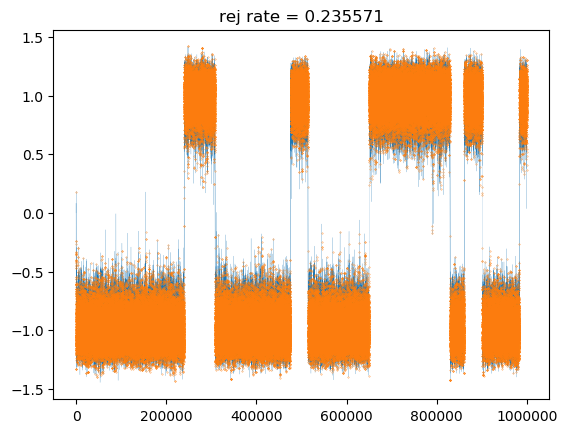

PyObject Text(0.5, 1.0, 'rej rate = 0.235571')

In [14]:
doplot(xmh)

In [15]:
function transitcount(x)
    count = 0
    for n=2:length(x)
        count += x[n]*x[n-1] < 0
    end
    return count
end

transitcount (generic function with 1 method)

In [16]:
transitcount(xmh)/nsteps

5.4e-5

*HMC results*

I have adjusted the number of steps so that the running time is roughly comparable to MH.  Here
$$
L = \frac{T}{\Delta{t}}.
$$

In [17]:
for L in 1:30
    let N=min(nsteps,round(Int,6.5/L*nsteps))
        @time xhmc = manysteps(HMCStepper(beta=beta,L=L,dt=5e-3),N)
        figure(figsize=[8,4])
        subplot(121)
        doplot(xhmc)
        ylabel("L=$L")
        subplot(122)
        pu.plotpdf(xmh; norm=:pdf,label="MH")
        pu.plotpdf(xhmc; norm=:pdf,label="HMC")
        let xl = -2:0.01:2
            plot(xl,map(x->exp(-beta*V(x)),xl);label="truth")
        end
        legend()
        title("transit rate = $(transitcount(xhmc)/N)")
    end
end

  0.107540 seconds (114.41 k allocations: 13.625 MiB)


UndefVarError: UndefVarError: pu not defined

**HMC without reversibility or volume conservation**

Let's try forward Euler.  Note time step has to be much smaller to maintain numerical stability.

In [18]:
function HMCEulerStepper(; beta=1, sigma=0.1, L=2, dt=0.005)
    m = sigma^2/beta
    H(q,p) = 0.5*p^2/m + beta*V(q)
    function onestep(x)
        p = p0 = sqrt(m)*randn()
        q = x
        for n=1:L
            pnew = p-beta*dt*DV(q)
            qnew = q+ dt/m * p
            p = pnew
            q = qnew
        end
        if rand() <= exp(-(H(q,p)-H(x,p0)))
            return q
        else
            return x
        end
    end
end

HMCEulerStepper (generic function with 1 method)

In [19]:
let L=10*500,
    N=min(nsteps,div(nsteps,10))
    
    @time xhmc = manysteps(HMCStepper(beta=beta,L=L,dt=1e-5),N)
    figure(figsize=[8,4])
    subplot(121)
    doplot(xhmc)
    ylabel("L=$L")
    subplot(122)
    pu.plotpdf(xmh; norm=:pdf,label="MH")
    pu.plotpdf(xhmc; norm=:pdf,label="HMC")
    let xl = -2:0.01:2
        plot(xl,map(x->exp(-beta*V(x)),xl);label="truth")
    end
    legend()
    title("transit rate = $(transitcount(xhmc)/N)")
end


  5.030733 seconds (13 allocations: 781.813 KiB)


UndefVarError: UndefVarError: pu not defined